# Данные по инсультам

Выведем информацию о столбцах датасета:

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import featuretools as ft
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

df = pd.read_csv("..//..//static//csv//healthcare-dataset-stroke-data.csv")

print(df.columns)
df.head()

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

### Определим бизнес цели и цели технического проекта.

1. Улучшение диагностики и профилактики инсульта.
    * Бизнес-цель: повышение точности прогнозирования риска инсульта среди пациентов для более раннего лечебного вмешательства. Определение основных факторов риска для более целенаправленного подхода в медицинском обслуживании.
    * Цель технического проекта: разработка статистической модели, которая решает задачу классификации и предсказывает возможность возникновения  инсульта у пациентов на основе имеющихся данных (возраст, гипертония, заболевания сердца и пр.), с целью выявления групп риска. Внедрение этой модели в систему поддержки принятия медицинских решений для врачей.
2. Снижение расходов на лечение инсультов.
    * Бизнес-цель: снижение затрат на лечение инсульта путем более эффективного распределения медицинских ресурсов и направленных профилактических мер.
    * Цель технического проекта: создание системы оценки индивидуального риска инсульта для пациентов, что позволит медучреждениям проводить профилактические меры среди целевых групп, сокращая расходы на лечение.

### И теперь проверим датасет на пустые значения:

In [137]:
# Количество пустых значений признаков
print(df.isnull().sum())

print()

# Есть ли пустые значения признаков
print(df.isnull().any())

print()

# Процент пустых значений признаков
for i in df.columns:
    null_rate = df[i].isnull().sum() / len(df) * 100
    if null_rate > 0:
        print(f"{i} процент пустых значений: %{null_rate:.2f}")

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

bmi процент пустых значений: %3.93


В столбце bmi можно заметить пустые значение. Заменим их на медиану:

In [138]:
# Замена значений
df["bmi"] = df["bmi"].fillna(df["bmi"].median())

# Проверка на пропущенные значения после замены
missing_values_after_drop = df.isnull().sum()

# Вывод результатов после замены
print("\nКоличество пустых значений в каждом столбце после замены:")
print(missing_values_after_drop)


Количество пустых значений в каждом столбце после замены:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


Удалим из датафрейма столбец id, потому что нет смысла учитывать его при предсказании:

In [139]:
df = df.drop('id', axis=1)
print(df.columns)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


### Можно перейти к созданию выборок

In [140]:
# Разделение данных на признаки (X) и целевую переменную (y)
# В данном случае мы хотим предсказать 'stroke'
X = df.drop(columns=['stroke'])
y = df['stroke']

# Разбиение данных на обучающую и тестовую выборки
# Сначала разделим на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Затем разделим обучающую выборку на обучающую и контрольную
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

# Проверка размеров выборок
print("Размер обучающей выборки:", X_train.shape)
print("Размер контрольной выборки:", X_val.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (2503, 10)
Размер контрольной выборки: (1074, 10)
Размер тестовой выборки: (1533, 10)


### Оценим сбалансированность выборок:

Распределение классов в обучающей выборке:
stroke
0    0.95006
1    0.04994
Name: proportion, dtype: float64

Распределение классов в контрольной выборке:
stroke
0    0.951583
1    0.048417
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
stroke
0    0.953033
1    0.046967
Name: proportion, dtype: float64


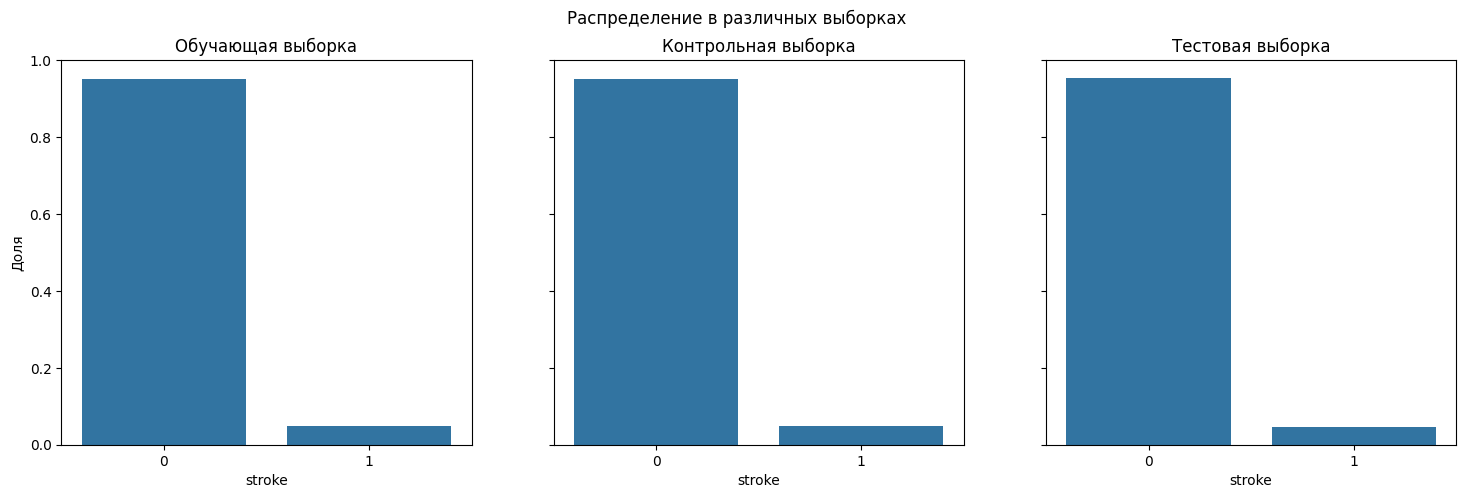

In [141]:
# Функция для анализа сбалансированности
def analyze_balance(y_train, y_val, y_test, y_name):
    # Распределение классов
    print("Распределение классов в обучающей выборке:")
    print(y_train.value_counts(normalize=True))
    
    print("\nРаспределение классов в контрольной выборке:")
    print(y_val.value_counts(normalize=True))
    
    print("\nРаспределение классов в тестовой выборке:")
    print(y_test.value_counts(normalize=True))

    # Создание фигуры и осей для трех столбчатых диаграмм
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle('Распределение в различных выборках')

    # Обучающая выборка
    sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts(normalize=True), ax=axes[0])
    axes[0].set_title('Обучающая выборка')
    axes[0].set_xlabel(y_name)
    axes[0].set_ylabel('Доля')

    # Контрольная выборка
    sns.barplot(x=y_val.value_counts().index, y=y_val.value_counts(normalize=True), ax=axes[1])
    axes[1].set_title('Контрольная выборка')
    axes[1].set_xlabel(y_name)

    # Тестовая выборка
    sns.barplot(x=y_test.value_counts().index, y=y_test.value_counts(normalize=True), ax=axes[2])
    axes[2].set_title('Тестовая выборка')
    axes[2].set_xlabel(y_name)

    plt.show()

analyze_balance(y_train, y_val, y_test, 'stroke')

Легко заметить, что выборки несбалансированны. Необходимо сбалансировать обучающую и контрольную выборки, чтобы получить лучшие результаты при обучении модели. Для балансировки применим RandomOverSampler:

Распределение классов в обучающей выборке:
stroke
0    0.5
1    0.5
Name: proportion, dtype: float64

Распределение классов в контрольной выборке:
stroke
0    0.5
1    0.5
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
stroke
0    0.953033
1    0.046967
Name: proportion, dtype: float64


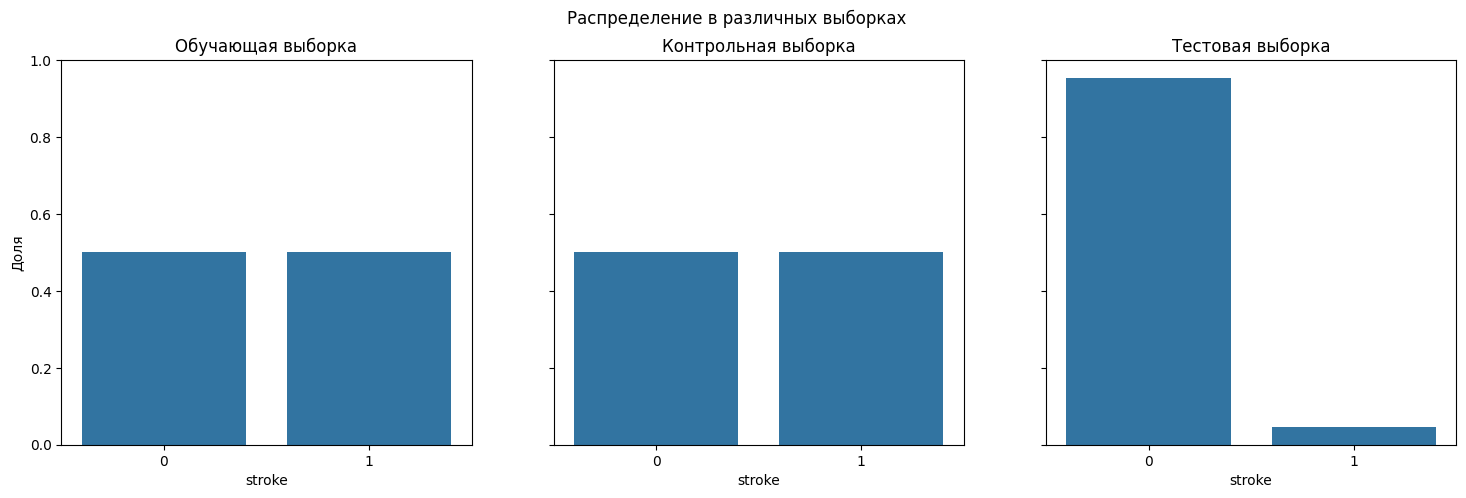

In [142]:
ros = RandomOverSampler(random_state=42)

# Применение RandomOverSampler для балансировки выборок
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
X_val_resampled, y_val_resampled = ros.fit_resample(X_val, y_val)

# Проверка сбалансированности после RandomOverSampler
analyze_balance(y_train_resampled, y_val_resampled, y_test, 'stroke')

Выборки сбалансированы.

### Перейдем к конструированию признаков

Для начала применим унитарное кодирование категориальных признаков (one-hot encoding), переведя их в бинарные вектора:

In [143]:
# Определение категориальных признаков
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Применение one-hot encoding к обучающей выборке
X_train_encoded = pd.get_dummies(X_train_resampled, columns=categorical_features, drop_first=True)

# Применение one-hot encoding к контрольной выборке
X_val_encoded = pd.get_dummies(X_val_resampled, columns=categorical_features, drop_first=True)

# Применение one-hot encoding к тестовой выборке
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

print(X_train_encoded.head())

    age  hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
0  78.0             0              0             137.74  34.9        False   
1  58.0             0              0              99.83  36.3         True   
2  77.0             0              0              59.91  18.3        False   
3  80.0             1              1             175.29  31.5         True   
4  58.0             1              0              59.52  33.2        False   

   gender_Other  ever_married_Yes  work_type_Never_worked  work_type_Private  \
0         False             False                   False              False   
1         False              True                   False              False   
2         False              True                   False              False   
3         False              True                   False               True   
4         False              True                   False              False   

   work_type_Self-employed  work_type_children  Re

Далее к числовым признакам, а именно к колонке age, применим дискретизацию (позволяет преобразовать данные из числового представления в категориальное):

In [144]:
# Определение числовых признаков для дискретизации
numerical_features = ['age']

# Функция для дискретизации числовых признаков
def discretize_features(df, features, bins, labels):
    for feature in features:
        df[f'{feature}_bin'] = pd.cut(df[feature], bins=bins, labels=labels)
        df.drop(columns=[feature], inplace=True)
    return df

# Заданные интервалы и метки
age_bins = [0, 25, 55, 100]
age_labels = ["young", "middle-aged", "old"]

# Применение дискретизации к обучающей, контрольной и тестовой выборкам
X_train_encoded = discretize_features(X_train_encoded, numerical_features, bins=age_bins, labels=age_labels)
X_val_encoded = discretize_features(X_val_encoded, numerical_features, bins=age_bins, labels=age_labels)
X_test_encoded = discretize_features(X_test_encoded, numerical_features, bins=age_bins, labels=age_labels)

print(X_train_encoded.head())

   hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
0             0              0             137.74  34.9        False   
1             0              0              99.83  36.3         True   
2             0              0              59.91  18.3        False   
3             1              1             175.29  31.5         True   
4             1              0              59.52  33.2        False   

   gender_Other  ever_married_Yes  work_type_Never_worked  work_type_Private  \
0         False             False                   False              False   
1         False              True                   False              False   
2         False              True                   False              False   
3         False              True                   False               True   
4         False              True                   False              False   

   work_type_Self-employed  work_type_children  Residence_type_Urban  \
0             

Применим ручной синтез признаков. Это создание новых признаков на основе существующих, учитывая экспертные знания и логику предметной области. К примеру, в этом случае можно создать признак, в котором вычисляется насколько уровень глюкозы отклоняется от среднего для возрастной группы пациента. Такой признак может быть полезен для выделения пациентов с нетипичными данными.

In [145]:
age_glucose_mean = X_train_encoded.groupby('age_bin', observed=False)['avg_glucose_level'].transform('mean')
X_train_encoded['glucose_age_deviation'] = X_train_encoded['avg_glucose_level'] - age_glucose_mean

age_glucose_mean = X_val_encoded.groupby('age_bin', observed=False)['avg_glucose_level'].transform('mean')
X_val_encoded['glucose_age_deviation'] = X_val_encoded['avg_glucose_level'] - age_glucose_mean

age_glucose_mean = X_test_encoded.groupby('age_bin', observed=False)['avg_glucose_level'].transform('mean')
X_test_encoded['glucose_age_deviation'] = X_test_encoded['avg_glucose_level'] - age_glucose_mean

print(X_train_encoded.head())

   hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
0             0              0             137.74  34.9        False   
1             0              0              99.83  36.3         True   
2             0              0              59.91  18.3        False   
3             1              1             175.29  31.5         True   
4             1              0              59.52  33.2        False   

   gender_Other  ever_married_Yes  work_type_Never_worked  work_type_Private  \
0         False             False                   False              False   
1         False              True                   False              False   
2         False              True                   False              False   
3         False              True                   False               True   
4         False              True                   False              False   

   work_type_Self-employed  work_type_children  Residence_type_Urban  \
0             

Теперь используем масштабирование признаков, что позволяет привести все числовые признаки к одинаковым или очень похожим диапазонам значений либо распределениям. По результатам многочисленных исследований масштабирование признаков позволяет получить более качественную модель за счет снижения доминирования одних признаков над другими.

In [146]:
# Пример масштабирования числовых признаков
numerical_features = ['avg_glucose_level', 'bmi', 'glucose_age_deviation']

scaler = StandardScaler()
X_train_encoded[numerical_features] = scaler.fit_transform(X_train_encoded[numerical_features])
X_val_encoded[numerical_features] = scaler.transform(X_val_encoded[numerical_features])
X_test_encoded[numerical_features] = scaler.transform(X_test_encoded[numerical_features])

print(X_train_encoded.head())

   hypertension  heart_disease  avg_glucose_level       bmi  gender_Male  \
0             0              0           0.366350  0.716465        False   
1             0              0          -0.312101  0.912920         True   
2             0              0          -1.026524 -1.612927        False   
3             1              1           1.038358  0.239361         True   
4             1              0          -1.033504  0.477913        False   

   gender_Other  ever_married_Yes  work_type_Never_worked  work_type_Private  \
0         False             False                   False              False   
1         False              True                   False              False   
2         False              True                   False              False   
3         False              True                   False               True   
4         False              True                   False              False   

   work_type_Self-employed  work_type_children  Residence_type

И также попробуем сконструировать признаки, используя фреймворк Featuretools:

In [147]:
data = X_train_encoded.copy()  # Используем предобработанные данные

es = ft.EntitySet(id="patients")

es = es.add_dataframe(dataframe_name="strokes_data", dataframe=data, index="index", make_index=True)

feature_matrix, feature_defs = ft.dfs(
    entityset=es, 
    target_dataframe_name="strokes_data",
    max_depth=1
)

print(feature_matrix.head())

       hypertension  heart_disease  avg_glucose_level       bmi  gender_Male  \
index                                                                          
0                 0              0           0.366350  0.716465        False   
1                 0              0          -0.312101  0.912920         True   
2                 0              0          -1.026524 -1.612927        False   
3                 1              1           1.038358  0.239361         True   
4                 1              0          -1.033504  0.477913        False   

       gender_Other  ever_married_Yes  work_type_Never_worked  \
index                                                           
0             False             False                   False   
1             False              True                   False   
2             False              True                   False   
3             False              True                   False   
4             False              True            

c:\Users\Ilya\Desktop\AIM\aimenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


### Оценим качество набора признаков.

Представим основные оценки качества наборов признаков: 

* Предсказательная способность (для задачи классификации) Метрики: Accuracy, Precision, Recall, F1-Score, ROC AUC

  Методы: Обучение модели на обучающей выборке и оценка на контрольной и тестовой выборках.

* Скорость вычисления 

  Методы: Измерение времени выполнения генерации признаков и обучения модели.

* Надежность 

  Методы: Кросс-валидация, анализ чувствительности модели к изменениям в данных.

* Корреляция 

  Методы: Анализ корреляционной матрицы признаков, удаление мультиколлинеарных признаков.

* Цельность 

  Методы: Проверка логической связи между признаками и целевой переменной, интерпретация результатов модели.

In [148]:
X_train_encoded = pd.get_dummies(X_train_encoded, drop_first=True)
X_val_encoded = pd.get_dummies(X_val_encoded, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_encoded, drop_first=True)

all_columns = X_train_encoded.columns
X_train_encoded = X_train_encoded.reindex(columns=all_columns, fill_value=0)
X_val_encoded = X_val_encoded.reindex(columns=all_columns, fill_value=0)
X_test_encoded = X_test_encoded.reindex(columns=all_columns, fill_value=0)

# Выбор модели
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Начинаем отсчет времени
start_time = time.time()
model.fit(X_train_encoded, y_train_resampled)

# Время обучения модели
train_time = time.time() - start_time

print(f'Время обучения модели: {train_time:.2f} секунд')

Время обучения модели: 0.64 секунд


In [149]:
# Получение важности признаков
importances = model.feature_importances_
feature_names = X_train_encoded.columns

# Сортировка признаков по важности
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

Feature Importance:
                           feature  importance
3                              bmi    0.186627
15           glucose_age_deviation    0.185001
2                avg_glucose_level    0.179305
17                     age_bin_old    0.166728
0                     hypertension    0.040494
16             age_bin_middle-aged    0.033330
11            Residence_type_Urban    0.028735
4                      gender_Male    0.028446
6                 ever_married_Yes    0.026005
1                    heart_disease    0.023176
13     smoking_status_never smoked    0.021729
14           smoking_status_smokes    0.019693
8                work_type_Private    0.018582
9          work_type_Self-employed    0.017155
12  smoking_status_formerly smoked    0.015585
10              work_type_children    0.009287
7           work_type_Never_worked    0.000118
5                     gender_Other    0.000002


Accuracy: 0.9425962165688193
Precision: 0.1
Recall: 0.027777777777777776
F1 Score: 0.043478260869565216
ROC AUC: 0.5077287246178417
Cross-validated Accuracy: 0.9926410942926067


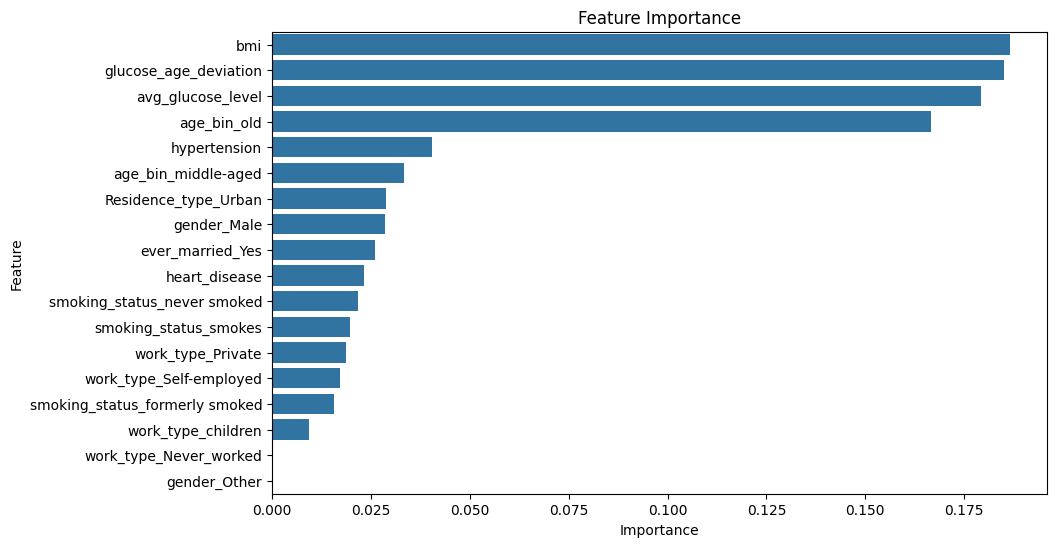

Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 Score: 1.0
Train ROC AUC: 1.0


In [150]:
# Предсказание и оценка
y_pred = model.predict(X_test_encoded)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

# Кросс-валидация
scores = cross_val_score(model, X_train_encoded, y_train_resampled, cv=5, scoring='accuracy')
accuracy_cv = scores.mean()
print(f"Cross-validated Accuracy: {accuracy_cv}")

# Анализ важности признаков
feature_importances = model.feature_importances_
feature_names = X_train_encoded.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

# Проверка на переобучение
y_train_pred = model.predict(X_train_encoded)

accuracy_train = accuracy_score(y_train_resampled, y_train_pred)
precision_train = precision_score(y_train_resampled, y_train_pred)
recall_train = recall_score(y_train_resampled, y_train_pred)
f1_train = f1_score(y_train_resampled, y_train_pred)
roc_auc_train = roc_auc_score(y_train_resampled, y_train_pred)

print(f"Train Accuracy: {accuracy_train}")
print(f"Train Precision: {precision_train}")
print(f"Train Recall: {recall_train}")
print(f"Train F1 Score: {f1_train}")
print(f"Train ROC AUC: {roc_auc_train}")